# Return-Oriented Failures in Personal Loans
## by Spencer McTavish

## Investigation Overview

Prosper is a fascinating financial instrument, allowing groups of individuals to back personal loans for others throughout the United States. Like any financial institution, investors on Prosper are looking for a return on their money in the form of an interest rate. They take some risk by lending out personal loans with the hope that they'll be getting additional funds back for it. 

You'd want to make your money back, right? What if that desire is getting in the way of actually getting your money back? 

## Dataset Overview

Prosper Loans is a company supplying individually backed loans to consumers throughout the US. The dataset they have shared includes 113,937 loans with 81 variables for each loan covering much of the data an interested lender would want. 

It also includes whether a loan has failed or not - that is to say, whether the loan has defaulted or been charged off on the books.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
#load dataset
loans = pd.read_csv('data/prosperLoanData.csv')
#grab completed loans only for review
loans_c = loans[loans['LoanStatus'].isin(['Completed','Defaulted','Chargedoff','Cancelled','FinalPaymentInProgress'])]

#CreditGrade is easier to write, so we'll maintain the ratings there. Any NA values found there will be filled by
#Prosper Rating values. Assume these are equivalent for now - we can go check this assumption by 

loans_c['CreditGrade'].fillna(loans_c['ProsperRating (Alpha)'],inplace = True)
loans_c['CreditGrade'].fillna('none',inplace=True)



## Who's Paying Back Their Loans?

Credit Grade is a good indicator of who will pay back their loans. People with higher credit ratings are much more likely to pay back their loans. 

This makes sense! The system works!

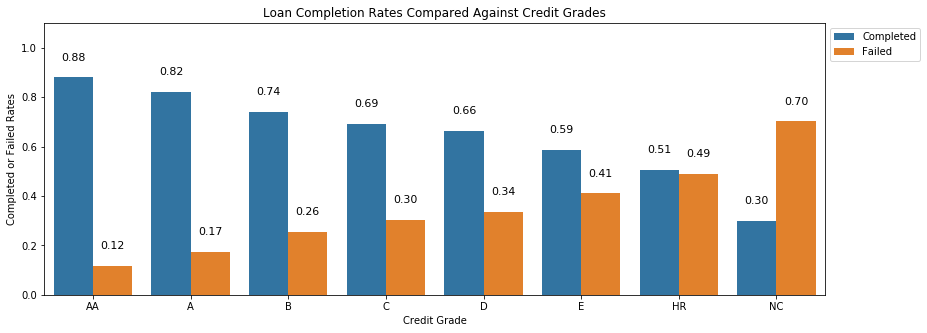

In [3]:
credit_order = ['AA','A','B','C','D','E','HR','NC','none']

# Group by Credit Grade, calculate a rate, and make a new dataframe called completion_rates
a = loans_c.groupby(['CreditGrade'])
completion_rates = a['LoanStatus'].value_counts() / a['CreditGrade'].count()
completion_rates = completion_rates.reset_index()
completion_rates.rename(columns = {0:'Rate'},inplace=True)
#copy existing dataframe
completion_rates_m = completion_rates.copy()
#generate a new dataframe, sort by Loan Status, and group by credit grade. Calculate combined failure rates and append new data
a = completion_rates_m[completion_rates_m['LoanStatus'].isin(['Chargedoff','Defaulted','Cancelled'])].groupby('CreditGrade')
b = a.sum()
b['LoanStatus'] = 'Failed'
b.reset_index(inplace=True)
completion_rates_m = completion_rates_m.append(b,ignore_index=True,sort=False)

##mask out 'none' values - they skew the representation of the data in this case
mask = completion_rates_m['CreditGrade'] != 'none'
credit_order_m = credit_order.copy()
credit_order_m.remove('none')

plt.subplots(figsize=(14,5))
#generate a barplot for the information.
#getting ride of 'none' data as it skews the overall results
g = sb.barplot(data=completion_rates_m[mask], x = 'CreditGrade',y='Rate',hue='LoanStatus',order =credit_order_m,
               ci=None,hue_order=['Completed','Failed'])
plt.legend(bbox_to_anchor=(1.00,1),loc=2)
plt.title('Loan Completion Rates Compared Against Credit Grades')
plt.ylim(0,1.1) #get some more room for the annotations
plt.xlabel('Credit Grade')
plt.ylabel('Completed or Failed Rates')

#add labelling for data points for easier comparison
#https://stackoverflow.com/questions/45946970/displaying-of-values-on-barchart - thanks!
for p in g.patches: 
    g.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

## Cost of a Loan

If we start thinking about the cost of a loan, it seems to make sense that people who are more likely to pay a loan back are less risky, and I don't need to make as much off of them. Borrower APR - the total rate paid by a borrower, including fees and the interest expected back from the investor - follows this logic. 

People with higher Credit Grades pay less for a loan. This makes sense. 

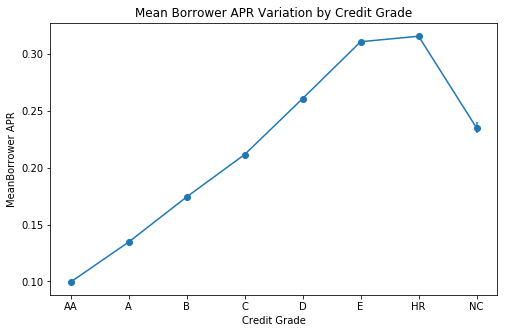

In [4]:
#generate an errorbar line-plot of borrower rates
#calculate means and standard error 
#mask out 'none' data. re-use revised credit_order_m from previous
mask = (loans_c['CreditGrade'] != 'none')
y_mean = loans_c[mask].groupby('CreditGrade')['BorrowerAPR'].mean()
y_sem = loans_c[mask].groupby('CreditGrade')['BorrowerAPR'].sem()

#re-order data to get it displaying correctly
y1 = []
y1_err = []
for i in credit_order_m:
    y1.append(y_mean[i])
    y1_err.append(y_sem[i])
    
plt.subplots(figsize=(8,5))

#plot errorbars
plt.errorbar(y=y1,x=credit_order_m,yerr=y1_err,fmt='o-')
plt.xlabel('Credit Grade')
plt.ylabel('MeanBorrower APR');
plt.title('Mean Borrower APR Variation by Credit Grade');

## Problematic Rates?

What happens when we compare loans that have failed against the successful ones. 

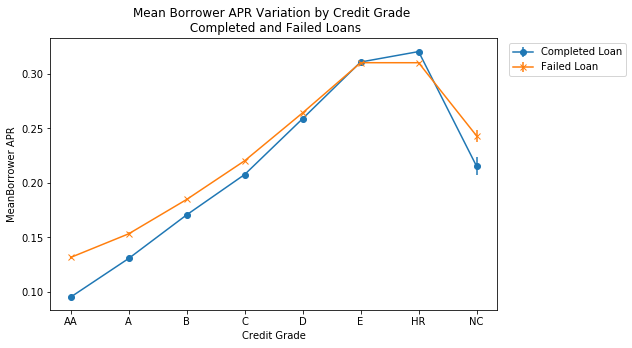

In [5]:
#convert Chargedoff, Cancelled and Defaulted to Failed loans
loans_c_m=loans_c.replace(to_replace=['Cancelled','Chargedoff','Defaulted'],value='Failed')

#calculate means and error for items of interest
mask = (loans_c['CreditGrade'] != 'none')

y_mean = loans_c_m[mask].groupby(['CreditGrade','LoanStatus'])['BorrowerAPR'].mean()
y_sem = loans_c_m[mask].groupby(['CreditGrade','LoanStatus'])['BorrowerAPR'].sem()

yc = []
yc_err = []
yf =[]
yf_err = []
#grab the appropraite data from our grouped dataframe
for i in credit_order_m:
    yc.append(y_mean[i]['Completed'])
    yc_err.append(y_sem[i]['Completed'])
    yf.append(y_mean[i]['Failed'])
    yf_err.append(y_sem[i]['Failed'])
 
#initialize a color map to keep consistent coloring
cmap = plt.get_cmap("tab10")
plt.subplots(figsize=(8,5))

#make errorbar plots of gathered data
plt.errorbar(y=yc,x=credit_order_m,yerr=yc_err,color=cmap(0),marker='o',linestyle='-')
plt.errorbar(y=yf,x=credit_order_m,yerr=yf_err,color=cmap(1),marker='x',linestyle='-')
plt.xlabel('Credit Grade')
plt.ylabel('MeanBorrower APR');
plt.title('Mean Borrower APR Variation by Credit Grade \n Completed and Failed Loans')
plt.legend(['Completed Loan','Failed Loan'],bbox_to_anchor=(1.3,1),loc=1);


### What's going on? 
Our failed loans have higher average Borrower APRs. This incldues our higher credit rating borrowers. 

A loan is made up of, effectively, fees associated with maintaining and place the loan, and the interest rate. This interest rate is what an investor is expecting to make back from a loan. 

Higher interest rates lead to higher investor returns, or investor yield.

### Problematic Pricing

Higher APRs suggest higher expected returns. Let's take a look at how our failed loans differ from the successful ones, in terms of how much money an investor was expecting to make off of a loan. 

Looking at the percentage of an APR an investor expects to make can shed some light on if a drive for profit is actually making loans more likely to fail.

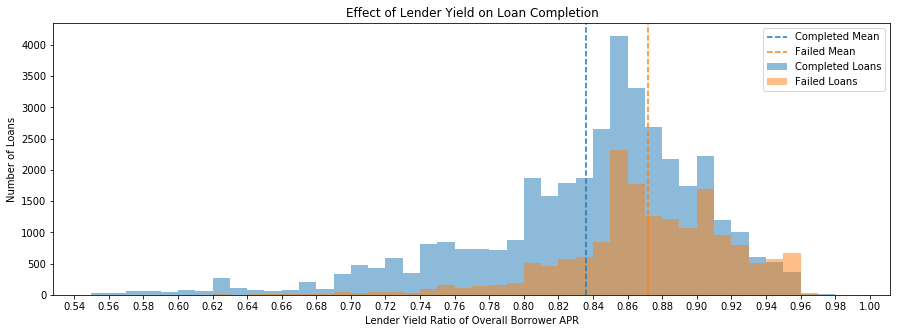

In [6]:
#generating new features for review
loans_c_m['LenderRateRatio']=loans_c_m['LenderYield'] / loans_c_m['BorrowerAPR']
loans_c_m['LenderRateDiff']= loans_c_m['BorrowerAPR'] - loans_c_m['LenderYield']

#setup dataframe mask and bin range
complete=loans_c_m['LoanStatus']=='Completed'
failed = loans_c_m['LoanStatus'] == 'Failed'
bins=np.arange(0.55,1,0.01)

#get colors, set figsize
cmap = plt.get_cmap("tab10")
plt.subplots(figsize=(15,5))

#plot completed loan distribution and the mean value
plt.hist(loans_c_m[complete]['LenderRateRatio'],bins=bins,alpha=0.5,label='Completed Loans',color=cmap(0))
plt.axvline(loans_c_m[complete]['LenderRateRatio'].mean(),linestyle='dashed',color=cmap(0),label = 'Completed Mean')

#plot failed loan distribution and the mean value
plt.hist(loans_c_m[failed]['LenderRateRatio'],bins=bins,alpha=0.5,label='Failed Loans',color=cmap(1));
plt.axvline(loans_c_m[failed]['LenderRateRatio'].mean(),linestyle='dashed',color=cmap(1),label='Failed Mean')

plt.legend();
plt.title('Effect of Lender Yield on Loan Completion');
plt.xlabel('Lender Yield Ratio of Overall Borrower APR');
plt.ylabel('Number of Loans');
plt.locator_params(nbins=25,axis='x');

Investors who want more of the overall APR for themselves are better represented amongst loans that fail. 

Let's look at the averages to see if there's a more accurate picture.

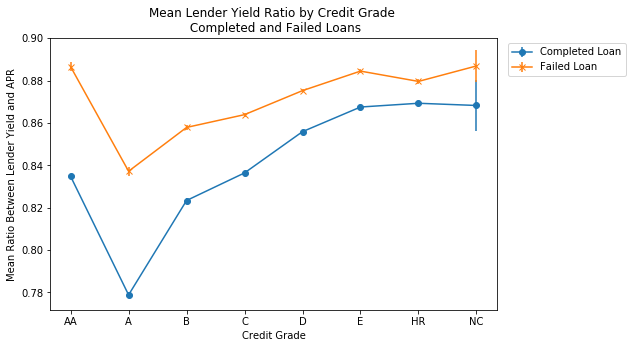

In [7]:
#calculate means and error for items of interest
mask = (loans_c_m['CreditGrade'] != 'none')

y_mean = loans_c_m[mask].groupby(['CreditGrade','LoanStatus'])['LenderRateRatio'].mean()
y_sem = loans_c_m[mask].groupby(['CreditGrade','LoanStatus'])['LenderRateRatio'].sem()

yc = []
yc_err = []
yf =[]
yf_err = []
#grab the appropraite data from our grouped dataframe
for i in credit_order_m:
    yc.append(y_mean[i]['Completed'])
    yc_err.append(y_sem[i]['Completed'])
    yf.append(y_mean[i]['Failed'])
    yf_err.append(y_sem[i]['Failed'])
 
#initialize a color map to keep consistent coloring
cmap = plt.get_cmap("tab10")
plt.subplots(figsize=(8,5))

#make errorbar plots of gathered data
plt.errorbar(y=yc,x=credit_order_m,yerr=yc_err,color=cmap(0),marker='o',linestyle='-')
plt.errorbar(y=yf,x=credit_order_m,yerr=yf_err,color=cmap(1),marker='x',linestyle='-')
plt.xlabel('Credit Grade')
plt.ylabel('Mean Ratio Between Lender Yield and APR');
plt.title('Mean Lender Yield Ratio by Credit Grade \n Completed and Failed Loans')
plt.legend(['Completed Loan','Failed Loan'],bbox_to_anchor=(1.3,1),loc=1);


There's a marked difference between lender yield ratio for failed and completed loans - between 5% and 10%, depending on the credit grade. 

Combining this insight with the overall failure rate for higher APRs, it seems like our investors are causing some problems for themselves. 

### High-Yield Risks

A common line of thinking in the loan world is that you want to make more money off of someone who is going to be a risky loan. You need to cover for loans that aren't paid back.

But why do our failed loans have higher APRs and investor yields across credit grades? 

There's a strong correlation between a loan failing, and higher investor yields. Our investors may be making it harder for themselves to get their money back by pushing for higher returns. 

There are a myriad of reasons for this - some loans could be perceived as risky, some investors are more risk adverse. Some people may just be greedy. Whatever the root cause, it's worth investigating to help ensure that investors can actually get their own money back at the end of a loan.

>Use to convert to slides
`jupyter nbconvert loans_slide_deck.ipynb --to slides --post serve --template output_toggle`